In [1]:
import pandas as pd 
import numpy as np  
import os

In [2]:
train_df=pd.read_csv("D:/yenaval/final_pro/archive (22)/train.csv")
train_df.head()

,No,material,feedrate,clamp_pressure,tool_condition,machining_finalized,passed_visual_inspection
0,1,wax,6,4.0,unworn,yes,yes
1,2,wax,20,4.0,unworn,yes,yes
2,3,wax,6,3.0,unworn,yes,yes
3,4,wax,6,2.5,unworn,no,NaN
4,5,wax,20,3.0,unworn,no,NaN


In [3]:
train_df.isnull().sum()

No                          0
material                    0
feedrate                    0
clamp_pressure              0
tool_condition              0
machining_finalized         0
passed_visual_inspection    4
dtype: int64

In [4]:
train_df.drop(columns=["material"], inplace=True)

In [5]:
train_df
train_df.to_csv('cleaned_train.csv', index=False)

In [ ]:
    import glob

    # folder paths
    experiment_folder = r"D:\yenaval\final_pro\archive (22)"
    cleaned_train_path = r"D:\yenaval\final_pro\cleaned_train.csv"

    # Load your cleaned data
    train_df = pd.read_csv(cleaned_train_path)
    print(f"Loaded cleaned_train.csv: {train_df.shape}")

    # Merge all 18 experiments
    merged_data = []
    for i in range(1, 19):
        filename = f"experiment_{i:02d}.csv"
        filepath = os.path.join(experiment_folder, filename)
        
        if os.path.exists(filepath):
            print(f"Loading: {filename}")
            exp_df = pd.read_csv(filepath)
            exp_df['experiment_id'] = i
            
            # Match with cleaned_train.csv
            metadata = train_df[train_df["No"] == i]
            if not metadata.empty:
                metadata_repeated = pd.concat([metadata] * len(exp_df), ignore_index=True)
                merged_df = pd.concat([exp_df.reset_index(drop=True), 
                                    metadata_repeated.reset_index(drop=True)], axis=1)
                merged_data.append(merged_df)
            else:
                print(f"No metadata for exp {i}")
        else:
            print(f" Missing: {filename}")

    # Final merged dataset
    final_df = pd.concat(merged_data, ignore_index=True)
    print(f"\n MERGED DATASET: {final_df.shape}")
    final_df.to_csv("merged_dataset.csv", index=False)
    print(" SAVED: merged_dataset.csv")
    print("\nTarget distribution:")
    print(final_df['tool_condition'].value_counts())


Loaded cleaned_train.csv: (18, 6)
Loading: experiment_01.csv
Loading: experiment_02.csv
Loading: experiment_03.csv
Loading: experiment_04.csv
Loading: experiment_05.csv
Loading: experiment_06.csv
Loading: experiment_07.csv
Loading: experiment_08.csv
Loading: experiment_09.csv
Loading: experiment_10.csv
Loading: experiment_11.csv
Loading: experiment_12.csv
Loading: experiment_13.csv
Loading: experiment_14.csv
Loading: experiment_15.csv
Loading: experiment_16.csv
Loading: experiment_17.csv
Loading: experiment_18.csv

 MERGED DATASET: (25286, 55)
 SAVED: merged_dataset.csv

Target distribution:
tool_condition
worn      13308
unworn    11978
Name: count, dtype: int64


 Loaded: (25286, 55)
Available targets: ['tool_condition', 'passed_visual_inspection']

 Features: (18, 6)

 TOOL WEAR MODEL
 Tool Wear Accuracy: 0.250

 VISUAL INSPECTION MODEL
 Visual Accuracy: 1.000

 MODELS SAVED!
 tool_wear_model.pkl
 feature_names.pkl


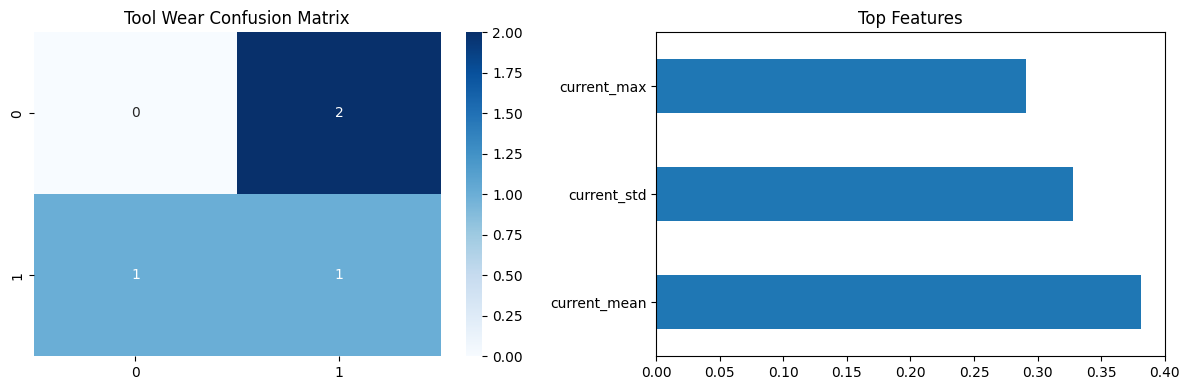

 Deliverables ready:
- merged_dataset.csv
- tool_wear_model.pkl
- feature_names.pkl
- final_results.png


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load merged data
df = pd.read_csv('merged_dataset.csv')
print(f" Loaded: {df.shape}")

# Feature Engineering 
current_cols = [col for col in df.columns if 'current' in col.lower() or 'Current' in col]
df['total_current'] = df[current_cols].sum(axis=1)

# AUTO-DETECT column names
target_cols = ['tool_condition', 'machiningfinalized', 'machining_completed', 'passed_visual_inspection']
available_targets = [col for col in target_cols if col in df.columns]
print(f"Available targets: {available_targets}")

# Per-experiment features
agg_dict = {'total_current': ['mean', 'std', 'max']}
for col in available_targets:
    if col in df.columns:
        agg_dict[col] = 'first'

summary_df = df.groupby('No').agg(agg_dict).reset_index()
summary_df.columns = ['experiment_id', 'current_mean', 'current_std', 'current_max'] + available_targets
print(f"\n Features: {summary_df.shape}")

#  FIX: Separate train_test_split for EACH model
print("\n TOOL WEAR MODEL")
y_tool = summary_df['tool_condition'].map({'unworn': 0, 'worn': 1})
X_tool = summary_df[['current_mean', 'current_std', 'current_max']].fillna(0)

X_train_tool, X_test_tool, y_train_tool, y_test_tool = train_test_split(X_tool, y_tool, test_size=0.2, random_state=42)
rf_tool = RandomForestClassifier(n_estimators=100, random_state=42)
rf_tool.fit(X_train_tool, y_train_tool)
print(f" Tool Wear Accuracy: {rf_tool.score(X_test_tool, y_test_tool):.3f}")

#  FIX: Separate train_test_split for Visual Inspection
if 'passed_visual_inspection' in summary_df.columns:
    print("\n VISUAL INSPECTION MODEL")
    y_visual = summary_df['passed_visual_inspection'].map({'Yes': 1, 'No': 0}).fillna(0)
    X_train_vis, X_test_vis, y_train_vis, y_test_vis = train_test_split(X_tool, y_visual, test_size=0.2, random_state=42)
    rf_visual = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_visual.fit(X_train_vis, y_train_vis)
    print(f" Visual Accuracy: {rf_visual.score(X_test_vis, y_test_vis):.3f}")

# SAVE MODELS
joblib.dump(rf_tool, 'tool_wear_model.pkl')
joblib.dump(X_tool.columns.tolist(), 'feature_names.pkl')
print("\n MODELS SAVED!")
print(" tool_wear_model.pkl")
print(" feature_names.pkl")

# FINAL PLOT
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test_tool, rf_tool.predict(X_test_tool)), annot=True, fmt='d', cmap='Blues')
plt.title('Tool Wear Confusion Matrix')

plt.subplot(1, 2, 2)
importances = pd.Series(rf_tool.feature_importances_, index=X_tool.columns).sort_values(ascending=False)
importances.head(10).plot(kind='barh')
plt.title('Top Features')

plt.tight_layout()
plt.savefig('final_results.png', dpi=300, bbox_inches='tight')
plt.show()


print(" Deliverables ready:")
print("- merged_dataset.csv")
print("- tool_wear_model.pkl") 
print("- feature_names.pkl")
print("- final_results.png")


In [12]:
import pandas as pd

# Check actual column names first
df = pd.read_csv('merged_dataset.csv')
print("=== COLUMN CHECK ===")
print("All columns:", df.columns.tolist())
print("\nTarget columns search:")
target_search = ['machining', 'completed', 'finalized', 'tool_condition', 'passed']
for col in df.columns:
    if any(word in col.lower() for word in target_search):
        print(f"  Found: '{col}'")

print(f"\nGroupBy columns available: {'No' in df.columns}")
print(f"Shape: {df.shape}")


=== COLUMN CHECK ===
All columns: ['X1_ActualPosition', 'X1_ActualVelocity', 'X1_ActualAcceleration', 'X1_CommandPosition', 'X1_CommandVelocity', 'X1_CommandAcceleration', 'X1_CurrentFeedback', 'X1_DCBusVoltage', 'X1_OutputCurrent', 'X1_OutputVoltage', 'X1_OutputPower', 'Y1_ActualPosition', 'Y1_ActualVelocity', 'Y1_ActualAcceleration', 'Y1_CommandPosition', 'Y1_CommandVelocity', 'Y1_CommandAcceleration', 'Y1_CurrentFeedback', 'Y1_DCBusVoltage', 'Y1_OutputCurrent', 'Y1_OutputVoltage', 'Y1_OutputPower', 'Z1_ActualPosition', 'Z1_ActualVelocity', 'Z1_ActualAcceleration', 'Z1_CommandPosition', 'Z1_CommandVelocity', 'Z1_CommandAcceleration', 'Z1_CurrentFeedback', 'Z1_DCBusVoltage', 'Z1_OutputCurrent', 'Z1_OutputVoltage', 'S1_ActualPosition', 'S1_ActualVelocity', 'S1_ActualAcceleration', 'S1_CommandPosition', 'S1_CommandVelocity', 'S1_CommandAcceleration', 'S1_CurrentFeedback', 'S1_DCBusVoltage', 'S1_OutputCurrent', 'S1_OutputVoltage', 'S1_OutputPower', 'S1_SystemInertia', 'M1_CURRENT_PROGRAM

 Features ready: (18, 5)
Target distribution:
machining_finalized
0.0    18
Name: count, dtype: int64
Train Acc: 1.000
Test Acc: 1.000

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         4

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



c:\Users\ALDO\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


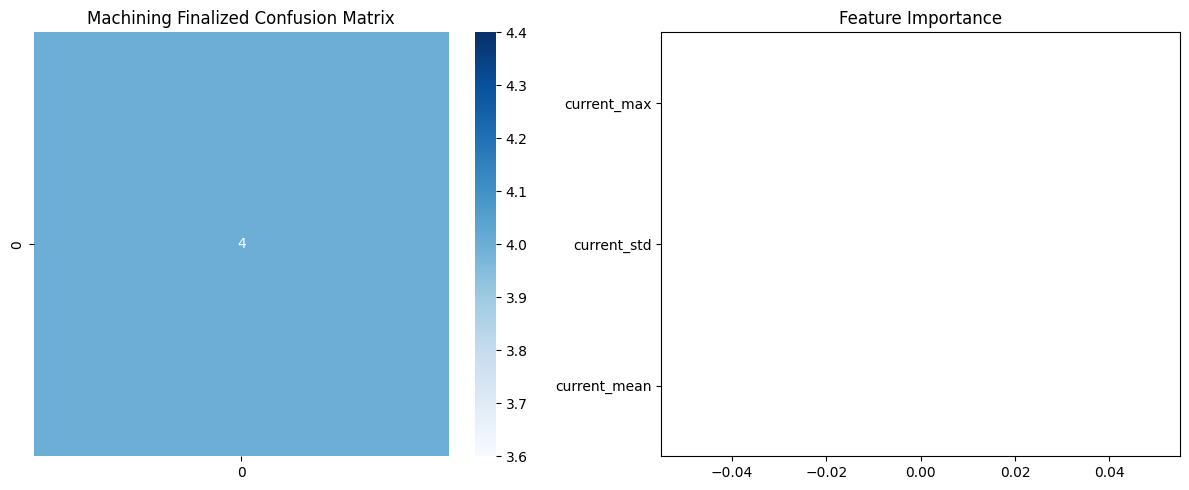

 machining_completion_model.pkl
 machining_feature_names.pkl
 machining_completion_results.png


In [15]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv('merged_dataset.csv')

# total_current feature
current_cols = [col for col in df.columns if 'current' in col.lower() or 'Current' in col]
df['total_current'] = df[current_cols].sum(axis=1)

agg_dict = {'total_current': ['mean', 'std', 'max'], 'machining_finalized': 'first'}
summary_df = df.groupby('No').agg(agg_dict).reset_index()
summary_df.columns = ['experiment_id', 'current_mean', 'current_std', 'current_max', 'machining_finalized']
print(f" Features ready: {summary_df.shape}")

# MACHINING COMPLETION MODEL
y_completion = summary_df['machining_finalized'].map({'Yes': 1, 'No': 0}).fillna(0)
X = summary_df[['current_mean', 'current_std', 'current_max']].fillna(0)

print("Target distribution:")
print(y_completion.value_counts())

X_train, X_test, y_train, y_test = train_test_split(X, y_completion, test_size=0.2, random_state=42, stratify=y_completion)
rf_completion = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_completion.fit(X_train, y_train)

print(f"Train Acc: {rf_completion.score(X_train, y_train):.3f}")
print(f"Test Acc: {rf_completion.score(X_test, y_test):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, rf_completion.predict(X_test)))

# Visualize & Save
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, rf_completion.predict(X_test)), annot=True, fmt='d', cmap='Blues')
plt.title('Machining Finalized Confusion Matrix')

plt.subplot(1, 2, 2)
pd.Series(rf_completion.feature_importances_, index=X.columns).sort_values(ascending=False).plot(kind='barh')
plt.title('Feature Importance')

plt.tight_layout()
plt.savefig('machining_completion_results.png', dpi=300, bbox_inches='tight')
plt.show()

# FINAL DELIVERABLE
joblib.dump(rf_completion, 'machining_completion_model.pkl')
joblib.dump(X.columns.tolist(), 'machining_feature_names.pkl')
print(" machining_completion_model.pkl")
print(" machining_feature_names.pkl") 
print(" machining_completion_results.png")


In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import joblib

# Load merged data and recreate features 
df = pd.read_csv('merged_dataset.csv')
current_cols = [col for col in df.columns if 'current' in col.lower() or 'Current' in col]
df['total_current'] = df[current_cols].sum(axis=1)

# Create summary dataset with ALL targets
agg_dict = {'total_current': ['mean', 'std', 'max']}
for target in ['tool_condition', 'passed_visual_inspection', 'machining_finalized']:
    if target in df.columns:
        agg_dict[target] = 'first'

summary_df = df.groupby('No').agg(agg_dict).reset_index()
summary_df.columns = ['experiment_id', 'current_mean', 'current_std', 'current_max', 
                     'tool_condition', 'passed_visual_inspection', 'machining_finalized']
X = summary_df[['current_mean', 'current_std', 'current_max']].fillna(0)

print("K-FOLD CROSS-VALIDATION (5-Fold)")
print("="*50)

# TOOL WEAR MODEL
y_tool = summary_df['tool_condition'].map({'unworn': 0, 'worn': 1})
cv_tool = cross_val_score(RandomForestClassifier(n_estimators=100, random_state=42), 
                         X, y_tool, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), 
                         scoring='accuracy')
print(f"Tool Wear CV Accuracy: {cv_tool.mean():.3f} ± {cv_tool.std():.3f}")

# VISUAL INSPECTION MODEL  
y_visual = summary_df['passed_visual_inspection'].map({'Yes': 1, 'No': 0}).fillna(0)
cv_visual = cross_val_score(RandomForestClassifier(n_estimators=100, random_state=42), 
                           X, y_visual, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), 
                           scoring='accuracy')
print(f"Visual Inspection CV: {cv_visual.mean():.3f} ± {cv_visual.std():.3f}")

# MACHINING MODEL
y_mach = summary_df['machining_finalized'].map({'Yes': 1, 'No': 0}).fillna(0)
cv_mach = cross_val_score(RandomForestClassifier(n_estimators=100, random_state=42), 
                         X, y_mach, cv=5, scoring='accuracy')
print(f"Machining CV: {cv_mach.mean():.3f} ± {cv_mach.std():.3f}")

print("Robust validation established!")


K-FOLD CROSS-VALIDATION (5-Fold)
Tool Wear CV Accuracy: 0.567 ± 0.178
Visual Inspection CV: 1.000 ± 0.000
Machining CV: 1.000 ± 0.000
Robust validation established!


In [20]:
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv('merged_dataset.csv')
print(f"Starting with {df.shape}")

# SIMPLE APPROACH: Define sensors and compute stats SEPARATELY
motors = ['X1', 'Y1', 'Z1', 'S1']
feature_types = ['ActualPosition', 'ActualVelocity', 'ActualAcceleration', 'OutputCurrent']

# Step 1: Create ALL features per experiment using standard groupby
feature_list = []
for motor in motors:
    for ftype in feature_types:
        col = f'{motor}_{ftype}'
        if col in df.columns:
            temp = df.groupby('No')[col].agg(['mean', 'std', 'max', 'var']).reset_index()
            temp.columns = ['No', f'{motor}_{ftype}_mean', f'{motor}_{ftype}_std', 
                           f'{motor}_{ftype}_max', f'{motor}_{ftype}_var']
            feature_list.append(temp)

# Merge all features horizontally
advanced_df = feature_list[0]
for feat_df in feature_list[1:]:
    advanced_df = advanced_df.merge(feat_df, on='No', how='outer')

# Add target columns
targets = ['tool_condition', 'passed_visual_inspection', 'machining_finalized']
for target in targets:
    if target in df.columns:
        target_df = df.groupby('No')[target].first().reset_index()
        advanced_df = advanced_df.merge(target_df, on='No', how='left')

print(f"ADVANCED FEATURES: {advanced_df.shape}")
advanced_df.to_csv('advanced_features.csv', index=False)

print("SUCCESS! Created advanced_features.csv")
print(f"Features: {advanced_df.shape[1]-4} mechanical features + 3 targets")
print("\nSample new features:")
print(advanced_df[['X1_ActualPosition_mean', 'S1_ActualVelocity_std', 'Z1_OutputCurrent_max']].head())


Starting with (25286, 55)
ADVANCED FEATURES: (18, 68)
SUCCESS! Created advanced_features.csv
Features: 64 mechanical features + 3 targets

Sample new features:
   X1_ActualPosition_mean  S1_ActualVelocity_std  Z1_OutputCurrent_max
0              151.998104               9.098133                   0.0
1              184.875300              21.887367                   0.0
2              160.480605              24.794696                   0.0
3              179.864662              23.755376                   0.0
4              187.904762              16.484176                   0.0


In [21]:
#Tool Wear with 64 features
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

advanced_df = pd.read_csv('advanced_features.csv')
feature_cols = [col for col in advanced_df.columns if any(ft in col for ft in ['mean','std','max','var'])]
X_advanced = advanced_df[feature_cols].fillna(0)
y_tool = advanced_df['tool_condition'].map({'unworn': 0, 'worn': 1})

cv_scores = cross_val_score(RandomForestClassifier(n_estimators=100), X_advanced, y_tool, 
                           cv=5, scoring='accuracy')
print(f" TOOL WEAR with 64 FEATURES: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")


 TOOL WEAR with 64 FEATURES: 0.367 ± 0.194


In [22]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
import numpy as np

# Load advanced features
df = pd.read_csv('advanced_features.csv')
feature_cols = [col for col in df.columns if any(ft in col for ft in ['mean','std','max','var'])]
X = df[feature_cols].fillna(0)
y_tool = df['tool_condition'].map({'unworn': 0, 'worn': 1})

print("FEATURE SELECTION + TUNING")

# Select TOP 10 features
selector = SelectKBest(f_classif, k=10)
X_selected = selector.fit_transform(X, y_tool)
selected_features = [feature_cols[i] for i in selector.get_support(indices=True)]
print(f"TOP 10 FEATURES: {selected_features[:5]}...")

# Hyperparameter tuning
rf = RandomForestClassifier(random_state=42)
param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, None]}
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_selected, y_tool)

print(f"BEST TOOL WEAR: {grid_search.best_score_:.3f}")
print(f"Best params: {grid_search.best_params_}")

# Final model with selected features
final_model = grid_search.best_estimator_
cv_final = cross_val_score(final_model, X_selected, y_tool, cv=5)
print(f"FINAL CV: {cv_final.mean():.3f} ± {cv_final.std():.3f}")

# Save best model
import joblib
joblib.dump(final_model, 'tool_wear_advanced.pkl')
joblib.dump(selected_features, 'best_features.pkl')
print("SAVED: tool_wear_advanced.pkl")


FEATURE SELECTION + TUNING
TOP 10 FEATURES: ['X1_ActualAcceleration_std', 'X1_ActualAcceleration_var', 'X1_OutputCurrent_std', 'X1_OutputCurrent_var', 'Y1_ActualAcceleration_std']...


c:\Users\ALDO\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [44 45 46 47] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\ALDO\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


BEST TOOL WEAR: 0.567
Best params: {'max_depth': 3, 'n_estimators': 50}
FINAL CV: 0.567 ± 0.178
SAVED: tool_wear_advanced.pkl
